In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\rupal\Anaconda3\envs\PythonData_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\rupal\Anaconda3\envs\PythonData_3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('data/train_clean.csv')
train_encoded = pd.read_csv('data/train_en_clean.csv')
#test = pd.read_csv('data/test_clean.csv')
#test_encoded = pd.read_csv('data/test_en_clean.csv')

In [3]:
train.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Outlet_Age,Item_Category
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,12.279885,1999,OUT049,Tier 1,Small,Supermarket Type1,20,FD
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,13.567337,2009,OUT018,Tier 3,Medium,Supermarket Type2,10,DR
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,11.100000,1999,OUT049,Tier 1,Small,Supermarket Type1,20,FD
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,10.300034,1998,OUT010,Tier 3,Small,Grocery Store,21,FD
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,9.100000,1987,OUT013,Tier 3,Small,Supermarket Type1,32,NC


### Evaluating the data using statsmodel 

In [4]:
model = ols('Item_Outlet_Sales ~ C(Item_Fat_Content) + Item_MRP + Item_Visibility + Item_Weight + C(Item_Category) \
                  + Outlet_Age + C(Outlet_Type) + C(Outlet_Size)', train).fit()

In [5]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1094.
Date:                Sun, 14 Jul 2019   Prob (F-statistic):               0.00
Time:                        22:01:01   Log-Likelihood:                -72001.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8512   BIC:                         1.441e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                             -93.7194     61.355     -1.527      0.127    -213.990      26.551
C(Item_Fat_Content)[T.Regular]         41.7005     28.303      1.473      0.141     -13.780      97.181
C(Item_Category)[T.FD]                 17.8136     43.972      0.405      0.685     -68.382     104.010
C(Item_Category)[T.NC]                -12.1773     49.059     -0.248      0.804    -108.344      83.990
C(Outlet_Type)[T.Supermarket Type1]  1927.7252     42.418     45.446      0.000    1844.576    2010.875
C(Outlet_Type)[T.Supermarket Type2]  -104.4156     37.859     -2.758      0.006    -178.629     -30.202
C(Outlet_Type)[T.Supermarket Type3]  1688.2666     48.453     34.843      0.000    1593.287    1783.246
C(Outlet_Size)[T.Small]             -1677.5704     39.981    -41.959      0.000   -1755.944   -1599.197
Item_MRP                               15.5568      0.197     79.071      0.000      15.171      15.943
Item_Visibility                      -295.6300    248.288     -1.191      0.234    -782.334     191.074
Item_Weight                             0.7331      2.695      0.272      0.786      -4.549       6.016
Outlet_Age                             -2.7272      2.158     -1.264      0.206      -6.958       1.503
==============================================================================
Omnibus:                      958.444   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2285.239
Skew:                           0.666   Prob(JB):                         0.00
Kurtosis:                       5.159   Cond. No.                     5.63e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.54e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The variance in actual and predicted values is 0.56. Looking at the The p-value and the coeffients we can see that the Outlet Age, Outlet Size, Outlet Type, and Item MRP are statitically significant predictors of sales. An increase in MRP will increase average sales by \\$16. Adding a smaller outlet(Grocery Store, Supermarket Type1) will decrease avg sales as compared to adding medium size outlets. Each item with Regular Fat Content will increase sales by \\$42 as compared to a Low Fat item.

###  Building models using scikit-learn

In [6]:
# Drop Item_Visibility and Item_Weight as they are not significant in predicting sales
train_encoded = train_encoded.drop(['Item_Visibility', 'Item_Weight'], \
                                   axis=1)

# Creating an array of the column names for later use
features = train_encoded.drop(['Item_Outlet_Sales'], axis=1).columns

# Creating feature and target numpy arrays
y = train_encoded.Item_Outlet_Sales.values
X = train_encoded.drop(['Item_Outlet_Sales'], axis=1).values 

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Linear Regression

In [7]:
# Building Linear Regression Model 

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [8]:
lr_score = r2_score(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(lr_mse)
print('R2 Score: ', round(lr_score,3)) 
print('Mean Squared Error: ',  round(int(lr_mse)))
print('Root Mean Squared Error: ', round(int(lr_rmse)))

R2 Score:  0.58
Mean Squared Error:  1140847
Root Mean Squared Error:  1068


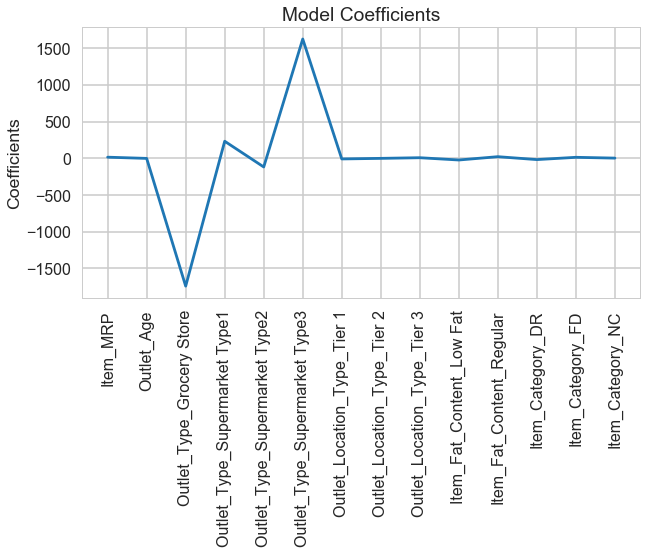

In [9]:
plt.figure(figsize=(10,5))

plt.plot(range(len(features)), lr.coef_)
plt.xticks(range(len(features)), features, rotation=90)
plt.ylabel('Coefficients')
plt.title('Model Coefficients')
plt.show()

### Lasso Regression

In [10]:
lasso = Lasso(alpha=0.3) #, normalize=True)
lasso = lasso.fit(X_train, y_train)
lasso_y_pred = lasso.predict(X_test)

In [11]:
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_score = r2_score(y_test, lasso_y_pred)
lasso_rmse = np.sqrt(lasso_mse)
print('R2 Score: ', round(lasso_score,3))
print('Mean Squared error: ', round(int(lasso_mse)))
print('Root Mean squared error: ', round(int(lasso_rmse)))


R2 Score:  0.58
Mean Squared error:  1140875
Root Mean squared error:  1068


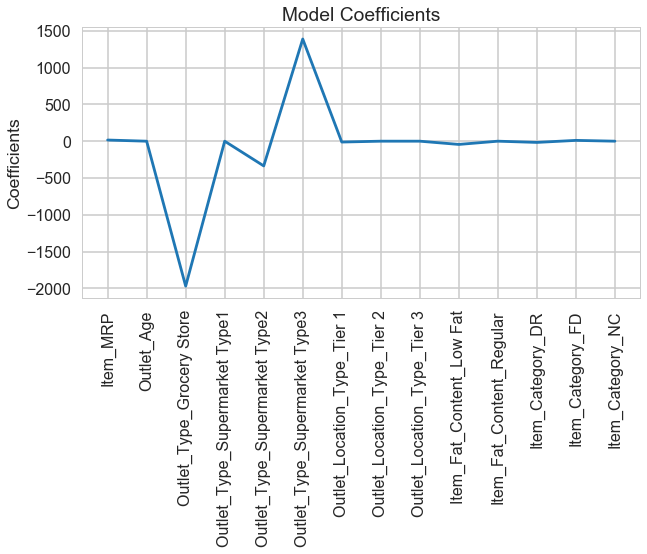

In [12]:
plt.figure(figsize=(10,5))

plt.plot(range(len(features)), lasso.coef_)
plt.xticks(range(len(features)), features, rotation=90)
plt.ylabel('Coefficients')
plt.title('Model Coefficients')
plt.show()

 
According to the Lasso model, the most important predictor is Supermarket_Type3.

### Random Forest


In [13]:
param_grid = {'n_estimators':[500, 1000], 
              'max_depth':[5, 10],  
              'min_samples_leaf':[10, 16] 
             }

In [14]:
forest = RandomForestRegressor() 
forest_cv= RandomizedSearchCV(forest, param_grid, n_iter=8) 
forest_cv = forest_cv.fit(X_train, y_train)

In [15]:
print('Best parameters: {}' .format(forest_cv.best_params_))

Best parameters: {'n_estimators': 500, 'min_samples_leaf': 16, 'max_depth': 5}


In [16]:
# Fit the model with the best parameters

#rf = RandomForestRegressor(n_estimators=8, max_depth=5, min_samples_leaf=16, n_jobs=7, random_state=42)
rf = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=16, n_jobs=4, random_state=42)
rf = rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [17]:
rf_score = r2_score(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred) 
rf_rmse = np.sqrt(rf_mse)

print('R2 Score: ', round(rf_score,3))
print('Mean Squared Error: ', round(int(rf_mse)))
print('Root Mean Squared Error: ', round(int(rf_rmse)))

R2 Score:  0.617
Mean Squared Error:  1041249
Root Mean Squared Error:  1020


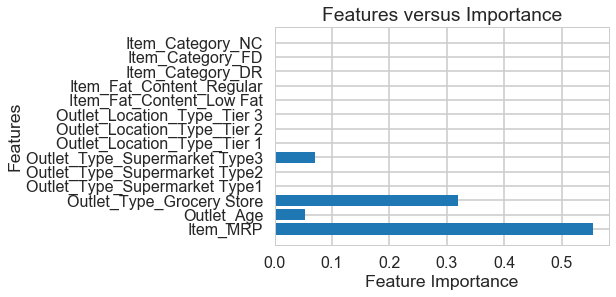

                         features  importance
0                        Item_MRP    0.555105
1                      Outlet_Age    0.053701
2       Outlet_Type_Grocery Store    0.318748
3   Outlet_Type_Supermarket Type1    0.000878
4   Outlet_Type_Supermarket Type2    0.000595
5   Outlet_Type_Supermarket Type3    0.070620
6     Outlet_Location_Type_Tier 1    0.000011
7     Outlet_Location_Type_Tier 2    0.000035
8     Outlet_Location_Type_Tier 3    0.000025
9        Item_Fat_Content_Low Fat    0.000115
10       Item_Fat_Content_Regular    0.000108
11               Item_Category_DR    0.000005
12               Item_Category_FD    0.000042
13               Item_Category_NC    0.000012


In [18]:
df = pd.DataFrame({'features':features, 'importance': rf.feature_importances_})
plt.barh(range(len(features)), rf.feature_importances_)
plt.yticks(range(len(features)), features)
plt.title('Features versus Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()
print(df)


Item_MRP, Outlet_Age and Outlet_Type are important predictors. Item_MRP is the most important variable in predicting sales. 

In [19]:
results = pd.DataFrame({'model':['linear', 'lasso', 'random forest'], 
                        'r2 score':[lr_score, lasso_score, rf_score],
                       'root mean sqr err':[lr_rmse, lasso_rmse, rf_rmse]})

In [20]:
results

,model,r2 score,root mean sqr err
0,linear,0.580258,1068.104406
1,lasso,0.580247,1068.117551
2,random forest,0.616902,1020.416567


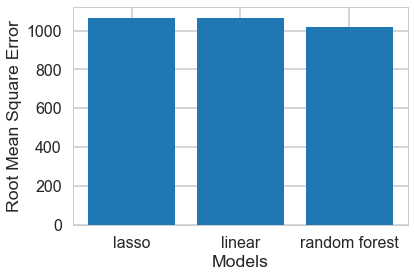

In [21]:
plt.bar(results.model, results['root mean sqr err'])
plt.xlabel('Models')
plt.ylabel('Root Mean Square Error')
plt.show()


After trying three different algorithms, Random Forest gave the the best score (RMSE: 1020)  